# 3.2. Prepare HitPredict protein-protein interaction network

Filter out interactions with low confidence score, convert protein IDs into gene locus names and remove self loops.

Confidence score threshold was set at 0.281 as recommended by López et al. (2015) to get high-quality interactions.

## Input
* `data-create_networks/hitpredit-03Aug2020/S_cerevisiae_interactions_MITAB-2.5.txt`: HitPredict protein-protein interactions for yeast as psi-mi 2.5 tab file.
* `data-create_networks/cross_ref-UniProt_SGD-17Jun2020/yeast.txt`: cross-references between UniProtKB and Saccharamyces Genome Database.

## Output

* `data-create_networks/hitpredit-03Aug2020/protein_protein_interactions.tsv`: cleaned HitPredict protein-protein interaction network.
* `data-create_networks/cross_ref-UniProt_SGD-17Jun2020/table.txt`: parsed table for the cross-references between UniProtKB and Saccharamyces Genome Database.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hitpredict_file = '../../data-create_networks/hitpredit-03Aug2020/S_cerevisiae_interactions_MITAB-2.5.txt'
crossRef_file = '../../data-create_networks/cross_ref-UniProt_SGD-17Jun2020/yeast.txt'
crossRefTable_file = '../../data-create_networks/cross_ref-UniProt_SGD-17Jun2020/table.txt'
ppiTable_file = '../../data-create_networks/hitpredit-03Aug2020/protein_protein_interactions.tsv'

## Import data

In [3]:
hitpred = pd.read_csv( hitpredict_file, sep='\t', header=None, skiprows=6 )[[ 0, 1, 14 ]].rename(
    {0: 'source', 1: 'target', 14: 'score'}, axis=1)

hitpred['source'] = hitpred['source'].str.replace('uniprotkb:', '')
hitpred['target'] = hitpred['target'].str.replace('uniprotkb:', '')

## Parse the table of SGD <> Swiss-Prot cross-references

In [3]:
with open(crossRef_file) as f: lines = [ line.rstrip() for line in f ][57:]
    
# parse the table
size_columns = [ len(c) for c in lines[0].split(' ') ]

correspondance = []
for line in lines[1:]:
    gene, start, end = [], 0, 0
    for c in range(len(size_columns)):
        # split the line according to the size of the column
        end = start+size_columns[c]
        gene.append( line[ start:end ].strip() )
        start = end+1
    correspondance.append( gene )
correspondance = pd.DataFrame(correspondance)

# as there are several gene names for a given locus, give one leach for each gene
df = list()
for i, gene_names in enumerate( correspondance[0].str.split('; ') ):
    row = correspondance.iloc[ i, : ]
    for n in gene_names: df.append( [ n ] + row.values[1:].tolist() )
df = pd.DataFrame(df, columns = ['gene name', 'locus name', 'Swiss-Prot AC', 'Swiss-Prot ID', 'SGD AC', 1, 2, 3, 4])

crossRef = df.iloc[ :-5, :5 ]

## Filter out low confidence score interactions

number of raw interactions: 126718
with score >= 0.281: 101078


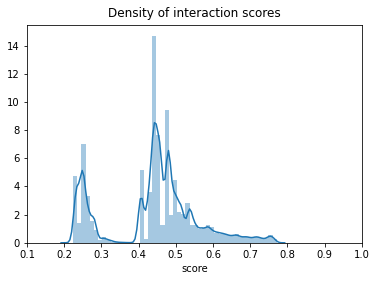

In [5]:
hitpred_filt = hitpred[ hitpred['score'] >= 0.281 ]

print( 'number of raw interactions:', len(hitpred) )
print( 'with score >= 0.281:', len(hitpred_filt) )

g = sns.distplot( hitpred.loc[ :, 'score' ] )
plt.xlim([0.1,1])
plt.title( 'Density of interaction scores', y=1.01 )
plt.show()

## Convert UniProt IDs to locus names

In [6]:
# get protein names to convert
proteins = pd.Series( list( set(hitpred_filt['source']) | set(hitpred_filt['target']) ) )
proteinsToConvert = crossRef[ crossRef['Swiss-Prot AC'].isin( proteins ) ]

print('proteins:', len(proteins))
print('unknown protein names:', len( proteins[ ~ proteins.isin( crossRef['Swiss-Prot AC'] ) ] ))

# get duplicated gene names and unknown gene names
duplicated_proteinIDs = proteinsToConvert[ proteinsToConvert.duplicated('Swiss-Prot AC') ][ 'Swiss-Prot AC' ].unique()

print('duplicated protein IDs within the cross-ref file:', len(duplicated_proteinIDs))

# convert protein names to locus names
conversionDict = { k: v for k, v in zip(
    proteinsToConvert['Swiss-Prot AC'].to_list(),
    proteinsToConvert['locus name'].to_list() ) } # most performant https://stackoverflow.com/a/33737067
hitpred_conv = hitpred_filt.replace(conversionDict)

proteins: 5543
unknown protein names: 0
duplicated protein IDs within the cross-ref file: 2051


## Clean interaction matrix

In [7]:
# check there are no redundant entries
x = hitpred_conv[['source', 'target']].copy()
x.values.sort()
print('no duplicated entry:', len( x.drop_duplicates() ) == len( hitpred_conv ))

# remove self loops
print( 'number of self loops:', len( hitpred_conv[ hitpred_conv['source'] == hitpred_conv['target'] ] ) )
ppi = hitpred_conv[ hitpred_conv['source'] != hitpred_conv['target'] ]

no duplicated entry: True
number of self loops: 1885


## Export

In [8]:
print('interactions:', len(ppi))
print('proteins:', len( set(ppi['source']) | set(ppi['target'])) )

interactions: 99193
proteins: 5532


In [9]:
ppi.to_csv( ppiTable_file, sep='\t', index=False )

In [11]:
crossRef.to_csv( crossRefTable_file, sep='\t', index=None )